공공데이터를 활용한 DBSCAN 예제

국토연구원 국토데이터랩 | 장요한 (ycanns@krihs.re.kr)

아래 샘플은

- https://www.localdata.go.kr/main.do

- https://csds.tistory.com/18

- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

- https://medium.com/analytics-vidhya/clustering-geo-location-dbscan-cadb33b0442e

등을 수정하여 활용하였습니다

1. INITIALIZATION

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00


In [ ]:
!pip install cartoframes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.5/245.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for carto: filename=carto-1.11.3-py3-none-any.whl size=35088 sha256=713d34800efd9916acdd701b75436b3b6a9583f9344092ee4e24ca3ed2742cbb
  Stored in directory: /root/.cache/pip/wheels/6b/a3/41/90fa4334cd280f91d17226f36db7a34b12902f7e5b281afb84
  Created wheel for pyrestcli: filename=pyrestcli-0.6.11-py3-none-any.whl size=8496 sha256=1230de31e28f7a1f1425bc7d875ffc62b7d9e05575917e3969fa7bb1c9f51a06
  Stored in directory: /root/.cache/pip/wheels/92/fc/98/2e46573b8e1bbe953345578314c765d3ecdc9532450bb90d79
Successfully built carto pyrestcli


In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773948 sha256=678b7d575d71f48f44860a19e40d5336b7bb054d3af9874ba9dd179b7dd239b8
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [ ]:
import pandas as pd
import geopandas as gpd
from cartoframes.viz import Layer, color_category_style
import numpy as np, matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interactive
from collections import defaultdict
import hdbscan
import folium
import re

2. IMPORT or UPLOAD file

In [ ]:
# https://www.localdata.go.kr/devcenter/dataDown.do?menuNo=20001
# 필요한 파일 업로드 기능 (구글 코랩)
from google.colab import files
uploaded = files.upload()

Saving 01_01_01_P.xlsx to 01_01_01_P.xlsx


In [ ]:
sample_data = pd.read_excel('01_01_01_P.xlsx')

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
sample_data.head()

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,진료과목내용명,지정취소일자,완화의료지정형태,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자
0,1,병원,01_01_01_P,3000000,PHMA220213000034021200002,20210624,NaN,1,영업/정상,13,...,"내과, 재활의학과, 한방내과, 한방부인과, 한방안·이비인후·피부과, 한방재활의학과,...",NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
1,2,병원,01_01_01_P,3000000,PHMA220213000034021200001,20210527,NaN,1,영업/정상,13,...,"내과, 산부인과, 가정의학과, 한방내과, 한방재활의학과, 침구과",NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
2,3,병원,01_01_01_P,3000000,PHMA219663000034021200001,19660119,NaN,3,폐업,03,...,"내과, 신경과, 정신건강의학과, 외과, 정형외과, 신경외과, 흉부외과, 성형외과, ...",NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
3,4,병원,01_01_01_P,3000000,PHMA220063000034021200001,20060803,NaN,3,폐업,03,...,"구강악안면외과, 치과보철과, 치과교정과, 소아치과, 치주과, 치과보존과, 구강내과,...",NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
4,5,병원,01_01_01_P,3000000,PHMA219823000034021200001,19820924,NaN,3,폐업,03,...,"내과, 영상의학과",NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN


In [ ]:
sample_data.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보(X)', '좌표정보(Y)',
       '의료기관종별명', '의료인수', '입원실수', '병상수', '총면적', '진료과목내용', '진료과목내용명', '지정취소일자',
       '완화의료지정형태', '완화의료담당부서명', '구급차특수', '구급차일반', '총인원', '구조사수', '허가병상수',
       '최초지정일자'],
      dtype='object')

3. SIMPLE DATA CLEANING

In [ ]:
# remove NA or empty values
sample_data = sample_data[(sample_data['좌표정보(X)'] == sample_data['좌표정보(X)']) & (sample_data['좌표정보(Y)'] == sample_data['좌표정보(Y)'])].copy()

In [ ]:
sample_data['좌표정보(X)'] = sample_data['좌표정보(X)'].astype(float)
sample_data['좌표정보(Y)'] = sample_data['좌표정보(Y)'].astype(float)

In [ ]:
# Coordinate change
sample_data_xy = gpd.GeoDataFrame(
    sample_data, geometry=gpd.points_from_xy(x=sample_data['좌표정보(X)'], y=sample_data['좌표정보(Y)'])
)
sample_data_xy.crs = "+proj=tmerc +lat_0=38 +lon_0=127.0028902777778 +k=1 +x_0=200000 +y_0=500000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43"
sample_data_xy = sample_data_xy.to_crs('EPSG:4326')

In [ ]:
sample_data_xy

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,지정취소일자,완화의료지정형태,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자,geometry
1,2,병원,01_01_01_P,3000000,PHMA220213000034021200001,20210527,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.97102 37.57226)
3,4,병원,01_01_01_P,3000000,PHMA220063000034021200001,20060803,NaN,3,폐업,03,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98604 37.56995)
5,6,병원,01_01_01_P,3000000,PHMA220103000034021200001,20080912,NaN,3,폐업,03,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.01530 37.57254)
6,7,병원,01_01_01_P,3000000,PHMA220083000034021200001,20080624,NaN,3,폐업,03,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.99036 37.57180)
7,8,병원,01_01_01_P,3000000,PHMA219793000034021200001,19790324,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.96810 37.56827)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,7010,병원,01_01_01_P,6520000,PHMA220136520074021200001,20131021,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56234 33.25278)
7012,7013,병원,01_01_01_P,6520000,PHMA219996520074021200001,19990208,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56546 33.25452)
7013,7014,병원,01_01_01_P,6520000,PHMA219946520074021200001,19940319,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56382 33.25590)
7014,7015,병원,01_01_01_P,6520000,PHMA220146520074021200001,20140124,NaN,1,영업/정상,13,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.44446 33.28615)


4. SIMPLE VISUALIZATION

In [ ]:
# 영업상태명으로 시각화 하기
Layer(sample_data_xy.sample(frac=1).iloc[:2000], color_category_style('영업상태명'))

In [ ]:
sample_data_xy.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보(X)', '좌표정보(Y)',
       '의료기관종별명', '의료인수', '입원실수', '병상수', '총면적', '진료과목내용', '진료과목내용명', '지정취소일자',
       '완화의료지정형태', '완화의료담당부서명', '구급차특수', '구급차일반', '총인원', '구조사수', '허가병상수',
       '최초지정일자', 'geometry'],
      dtype='object')

5. ADDITONAL TASK for DBSCAN

In [ ]:
sample_data_xy['lon'] = sample_data_xy.geometry.x
sample_data_xy['lat'] = sample_data_xy.geometry.y
sample_data['lon'] = sample_data_xy.geometry.x
sample_data['lat'] = sample_data_xy.geometry.y
coords = sample_data_xy[['lat', 'lon']].to_numpy()

In [ ]:
coords

array([[ 37.57226208, 126.97101616],
       [ 37.56995017, 126.98603649],
       [ 37.57253586, 127.01530435],
       ...,
       [ 33.25590098, 126.56382023],
       [ 33.28614892, 126.44445548],
       [ 33.24214358, 126.56438   ]])

6. NUMBER of CLUSTERS for DBSCAN

In [ ]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 810


7. CLUSTER's CENTER-MOST POINT

In [ ]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [ ]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [ ]:
rs = rep_points.apply(lambda row: sample_data_xy[(sample_data_xy['lat']==row['lat']) & (sample_data_xy['lon']==row['lon'])].iloc[0], axis=1)

In [ ]:
rs.head()

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자,geometry,lon,lat
0,106,병원,01_01_01_P,3050000,PHMA219713050034021200001,19710821,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.0513948550713 37.596712227916306),127.051395,37.596712
1,13,병원,01_01_01_P,3000000,PHMA220123000034021200001,20120516,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.96921767743501 37.60681979342828),126.969218,37.606820
2,14,병원,01_01_01_P,3000000,PHMA219893000034021200002,19891012,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98286234677985 37.58805736383847),126.982862,37.588057
3,34,병원,01_01_01_P,3020000,PHMA219843020033021200001,19840403,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98194955484925 37.51760948493716),126.981950,37.517609
4,40,병원,01_01_01_P,3020000,PHMA219783020033021200001,19780223,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.00430683742276 37.53370710196889),127.004307,37.533707


In [ ]:
vis_rs = gpd.GeoDataFrame(
    rs, geometry=gpd.points_from_xy(x=rs['lon'], y=rs['lat'])
)

In [ ]:
vis_rs

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자,geometry,lon,lat
0,106,병원,01_01_01_P,3050000,PHMA219713050034021200001,19710821,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.05139 37.59671),127.051395,37.596712
1,13,병원,01_01_01_P,3000000,PHMA220123000034021200001,20120516,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.96922 37.60682),126.969218,37.606820
2,14,병원,01_01_01_P,3000000,PHMA219893000034021200002,19891012,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98286 37.58806),126.982862,37.588057
3,34,병원,01_01_01_P,3020000,PHMA219843020033021200001,19840403,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98195 37.51761),126.981950,37.517609
4,40,병원,01_01_01_P,3020000,PHMA219783020033021200001,19780223,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.00431 37.53371),127.004307,37.533707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,6983,병원,01_01_01_P,6510000,PHMA219836510096021200002,19831029,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.48493 33.49036),126.484926,33.490359
806,6996,병원,01_01_01_P,6510000,PHMA220106510097021200001,20101028,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.26903 33.41825),126.269028,33.418251
807,6989,병원,01_01_01_P,6510000,PHMA220076510097021200002,20071130,NaN,3,폐업,03,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.44144 33.45660),126.441438,33.456603
808,7001,병원,01_01_01_P,6510000,PHMA220146510098021200001,20140902,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.64049 33.51865),126.640487,33.518648


In [ ]:
# Distribution for the center-most points
Layer(vis_rs.sample(frac=1).iloc[:2000], color_category_style('영업상태명'))

8. VISUALIZATION BETWEEN CENTER-MOST vs. ORIGINAL

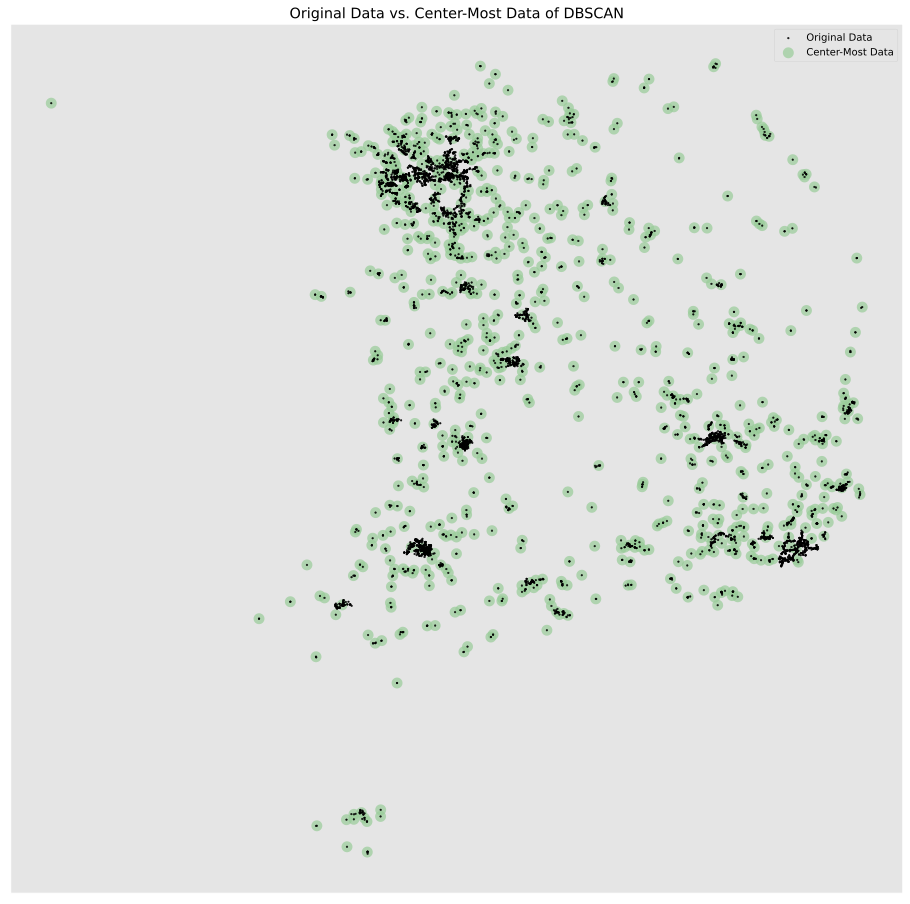

In [ ]:
fig, ax = plt.subplots(figsize=[16, 16])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(sample_data['lon'], sample_data['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Original Data vs. Center-Most Data of DBSCAN')
plt.xticks([])
plt.yticks([])
ax.legend([df_scatter, rs_scatter], ['Original Data', 'Center-Most Data'], loc='upper right')
plt.show()

9. DBSCAN VISUALIZATION

In [ ]:
# Pre-set for color set
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*100
sns.set(style="white")

In [ ]:
sample_data_xy.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보(X)', '좌표정보(Y)',
       '의료기관종별명', '의료인수', '입원실수', '병상수', '총면적', '진료과목내용', '진료과목내용명', '지정취소일자',
       '완화의료지정형태', '완화의료담당부서명', '구급차특수', '구급차일반', '총인원', '구조사수', '허가병상수',
       '최초지정일자', 'geometry', 'lon', 'lat'],
      dtype='object')

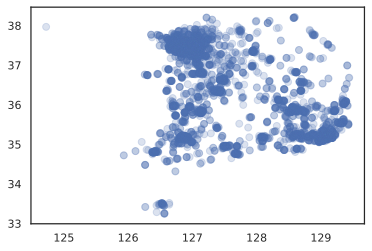

In [ ]:
# Simple Visualization
X = np.array(sample_data_xy[['lon', 'lat']])
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

10. BEFORE DBSCAN vs. AFTER DBSCAN

In [ ]:
# All Data Visualization
m = folium.Map(location=[sample_data_xy.lat.mean(), sample_data_xy.lon.mean()], zoom_start=9, 
               tiles='OpenStreet Map')
for _, row in sample_data_xy.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=5,
        #popup=re.sub(r'[^a-zA-Z ]+', '', row['영업상태명']),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sample_data_xy

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자,geometry,lon,lat
1,2,병원,01_01_01_P,3000000,PHMA220213000034021200001,20210527,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.97102 37.57226),126.971016,37.572262
3,4,병원,01_01_01_P,3000000,PHMA220063000034021200001,20060803,NaN,3,폐업,03,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.98604 37.56995),126.986036,37.569950
5,6,병원,01_01_01_P,3000000,PHMA220103000034021200001,20080912,NaN,3,폐업,03,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (127.01530 37.57254),127.015304,37.572536
6,7,병원,01_01_01_P,3000000,PHMA220083000034021200001,20080624,NaN,3,폐업,03,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.99036 37.57180),126.990363,37.571801
7,8,병원,01_01_01_P,3000000,PHMA219793000034021200001,19790324,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.96810 37.56827),126.968098,37.568268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,7010,병원,01_01_01_P,6520000,PHMA220136520074021200001,20131021,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56234 33.25278),126.562344,33.252775
7012,7013,병원,01_01_01_P,6520000,PHMA219996520074021200001,19990208,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56546 33.25452),126.565462,33.254521
7013,7014,병원,01_01_01_P,6520000,PHMA219946520074021200001,19940319,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.56382 33.25590),126.563820,33.255901
7014,7015,병원,01_01_01_P,6520000,PHMA220146520074021200001,20140124,NaN,1,영업/정상,13,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,POINT (126.44446 33.28615),126.444455,33.286149


In [ ]:
# DBSCAN
def create_map(df, CLUSTERS_DBSCAN):
    m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=9, tiles='OpenStreet Map')
    
    for _, row in df.iterrows():
      if row[CLUSTERS_DBSCAN] == -1:
        cluster_colour = '#000000'
      else:
        cluster_colour = cols[row[CLUSTERS_DBSCAN]]
        folium.CircleMarker(
            location= [row['lat'], row['lon']],
            radius=5,
            popup= row[CLUSTERS_DBSCAN],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_
sample_data_xy['CLUSTERS_DBSCAN'] = class_predictions
m = create_map(sample_data_xy, 'CLUSTERS_DBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 227
Number of outliers found: 1666
Silhouette ignoring outliers: 0.5250152533943547
Silhouette outliers as singletons: 0.1910429640059834


In [ ]:
m

Output hidden; open in https://colab.research.google.com to view.

In [39]:
m.save("test_map.html")

END Code